# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy
import textstat
import readability
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
pd.set_option('display.max_columns', 102)
pd.set_option('display.max_rows', 50)

# Introduction

With the higher penetration of internet worldwide comes the rise of ecommerce. More businesses, online or brick and mortar , are using customer's reviews to stand out from the competition. More consumers are also relying on online reviews for purchase decision making.<br>
<br>
With online reviews getting more popular, reviews are becoming a tool whereby business seeks to improve sales. Business can also be targeted with fake review to tarish the reputation.<br>

# Data sources

Reading online reviews and labelling fake reviews is diffcult and there is no publicly available datasets. Yelp is a online business which publish crowd-sourced reviews on businesses. Yelp have a in-house algorithm that filters reviews into recommended and non-recommended reviews. While it is not perfect, it had been recognised as accurate in filtering fake reviews.[2] Hence it is also considered near ground truth.<br>
<br>
I had obtained labelled dataset for Yelp from Professor Shebuti Rayana[1]. This dataset is dated from 2004 to 2015 on restuarants in the US. 

# Problem Statement

I want to train a machine learning classifier model to predict whether a review posted on Yelp is recommended/spam/genuine or not recommended/ham/fake. This should give insights on some features of a spam/fake/not recommended review.

# Data importing / Cleaning

In [3]:
#import metadata of the reviews and the reviews of first dataset
first_metadata = pd.read_csv('./datasets/YelpNYC/metadata', delimiter = "\t", header=None, names =['user_id','prod_id','rating','label','date'])
first_review = pd.read_csv('./datasets/YelpNYC/reviewContent', delimiter = "\t", header=None, names =['user_id','prod_id','date','review'])

In [4]:
#checking first 5 rows of metadata
first_metadata.head()

,user_id,prod_id,rating,label,date
0,923,0,3.0,-1,2014-12-08
1,924,0,3.0,-1,2013-05-16
2,925,0,4.0,-1,2013-07-01
3,926,0,4.0,-1,2011-07-28
4,927,0,4.0,-1,2010-11-01


In [5]:
#checking first 5 rows of review
first_review.head()

,user_id,prod_id,date,review
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...
1,924,0,2013-05-16,This little place in Soho is wonderful. I had ...
2,925,0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,926,0,2011-07-28,This is a beautiful quaint little restaurant o...
4,927,0,2010-11-01,Snack is great place for a casual sit down lu...


In [6]:
#checking number of rows and columns
first_metadata.shape, first_review.shape

((359052, 5), (358957, 4))

The observations are different in rows, with fewer reviews than metadata. This indicates there are some missing reviews.

In [7]:
cols = ['user_id','prod_id','date'] #defining which columns to match and join review on
final_dataset = first_metadata.join(first_review.set_index(cols), on=cols) #joining metadata and review

In [8]:
# checking for null values
final_dataset.isnull().sum()

user_id     0
prod_id     0
rating      0
label       0
date        0
review     95
dtype: int64

In [9]:
final_dataset.shape

(359052, 6)

In [10]:
final_dataset['label'].value_counts()

 1    322167
-1     36885
Name: label, dtype: int64

There are total 95 missing reviews. We will drop these missing values later.

The label column indicates whether the reviews are considered recommended or not recommended. Recommended review bear the value 1 while not recommended reviews bear the value -1.

In [11]:
#to change non recommended review to -1, and recommended review to 0.
final_dataset['label'] = final_dataset['label'].map({-1:1,1:0})

In [12]:
#checking the distribution again
final_dataset['label'].value_counts()

0    322167
1     36885
Name: label, dtype: int64

In [13]:
#checking the number of observations before dropping rows with missing reviews
final_dataset.shape

(359052, 6)

In [14]:
#drop rows with missing reviews
final_dataset.dropna(inplace=True)

In [15]:
#checking final shape of dataset
final_dataset.shape

(358957, 6)

In [17]:
#checking the final distribution of labels.
final_dataset['label'].value_counts()

0    322097
1     36860
Name: label, dtype: int64

The dataset is highly unbalanced with only 10% of the reviews as not recommended.<br>
<br>
There are total 36,860 non-recommended reviews and 322,097 recommended reviews. Thus I will perform unsampling of the recommended reviews based on user_id.

### Downsample

In [18]:
import random
random.seed(42)

In [19]:
# all user_id with non-recommended review
user_id_fake = list(set(final_dataset[final_dataset['label']==1]['user_id'].values))

In [20]:
# all user_id with recommended review
user_id_real = list(set(final_dataset[final_dataset['label']==0]['user_id'].values))

In [21]:
# user_id with no non-recommended review
users_with_no_fake = []
for user in user_id_real:
    if user not in user_id_fake:
        users_with_no_fake.append(user)

In [22]:
# unique user_id with no non-recommended review
users_with_no_fake = list(set(users_with_no_fake))

In [23]:
#length of user_ids with fake reviews and no fake reviews
len(users_with_no_fake), len(user_id_fake), len(set(final_dataset['user_id'].values)) 

(131718, 28483, 160201)

Next we will random select 30,000 user_id with no non-recommended review. Together with all the user_id with non-recommended review. They will form our selected user_id and the finalized dataset.

In [24]:
# random select 30,000 user_id
selected_user_id = np.random.choice(users_with_no_fake,size=30000)

In [25]:
# merge with our user_id with non-recommended reviews
selected_user_id = user_id_fake + list(selected_user_id)

In [26]:
#filter the final dataset with all the selected user_id
final = final_dataset[final_dataset['user_id'].isin(selected_user_id)]

In [27]:
final.shape

(105409, 6)

The final datset is about 30% of our original dataset.

## Data Dictionary

|Feature|Type|Description|
|---|---|---|
|user_id|object|Unique ID of user|
|prod_id|object|Unique ID of restaurant|
|rating|object||Rating given by user to restaurants. Can take values 1,2,3,4,5|
|date|object|Date of posted review by user|
|review|object|Review posted by user|
|label|int64|1 - Not Recommended review, 0 - Recommended review|
|month|object|Month of posted review by user|
|year|object|Year of posted review by user|

# Exploratory Data Analysis / Features Engineering

In [37]:
#checking the first 5 rows
final.head()

,user_id,prod_id,rating,label,date,review,month,year
0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,12,2014
1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...,5,2013
2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,7,2013
3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...,7,2011
4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...,11,2010


There are a number of features that we might want to explore. Examples are number of times a user had posted a review, number of 5 rating given by a user, number of times a restaurant had received reviews etc.<br>
<br>
These will be explained in details in this section.

In [38]:
from wordcloud import WordCloud

def draw_wordcloud(text, plot_title=None):
    """
    Generate and draw word cloud from text.
    
    Parameters
    ----------
    text : str
        Text to generate word cloud from.
    title : str
        Title to set on plot
    mask_img: str
        Path to image mask
    """


    wordcloud = WordCloud(
        scale=7,
        max_words=1000,
        background_color='white',
        colormap='brg',
        contour_width=3,
        contour_color='steelblue',
        random_state=42
    ).generate(text)
    plt.figure(figsize=(14,14), facecolor='white')
    plt.imshow(wordcloud, interpolation="bilinear")
    if plot_title:
        plt.title(plot_title, fontsize=20, pad=50)
    plt.axis("off")
    plt.show()

## Distribution of ratings

In [28]:
#change date data type
final['date'] = pd.to_datetime(final['date'])

In [29]:
#new column with year of review posting date
final['month'] = [x.month for x in final['date']]

In [30]:
#new column with year of review posting date
final['year'] = [x.year for x in final['date']]

In [31]:
#distribution of the data according to year
final.groupby('year')['year'].count()

year
2005       82
2006      395
2007     1251
2008     2748
2009     5626
2010     9631
2011    14749
2012    17003
2013    22824
2014    30470
2015      630
Name: year, dtype: int64

In [36]:
# distribution of our labels
final['label'].value_counts(normalize=True)

0    0.650314
1    0.349686
Name: label, dtype: float64

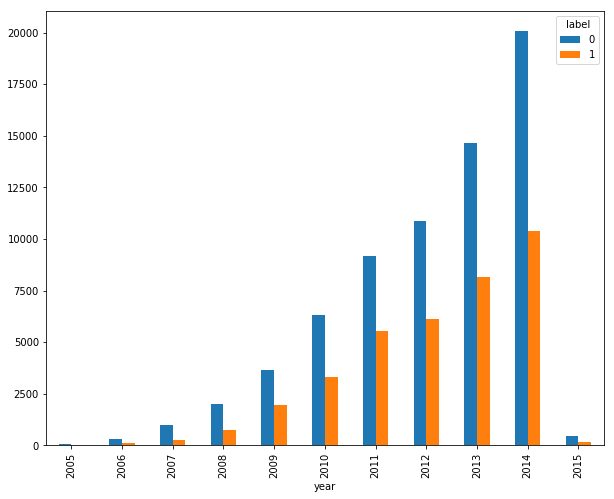

In [33]:
final.groupby(['year','label']).size().unstack(fill_value=0).plot.bar(figsize=(10,8))

The non-recommended reviews is lesser than the recommended reviews. and follows closely with the distribution of the recommended reviews.<br>
<br>

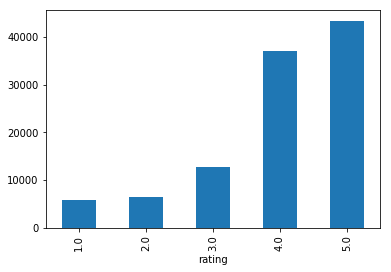

In [40]:
final.groupby('rating')['rating'].count().plot.bar()

There are significant more 4 and 5 ratings than the rest. 1 rating are the fewest. 

In [41]:
# distribution of ratings between recommended and not recommended reviews
final.groupby(['rating', 'label'])['review'].count()

rating  label
1.0     0         2305
        1         3566
2.0     0         4073
        1         2391
3.0     0         9544
        1         3167
4.0     0        26265
        1        10732
5.0     0        26362
        1        17004
Name: review, dtype: int64

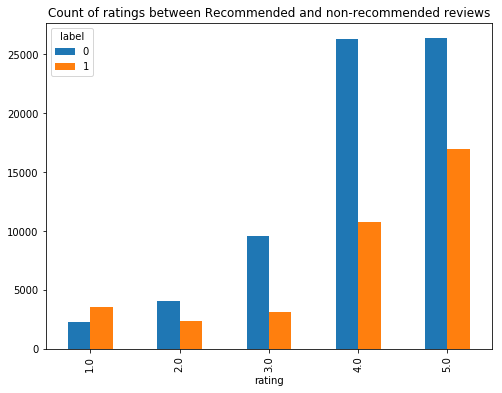

In [42]:
final.groupby(['rating', 'label']).size().unstack(fill_value=0).plot.bar(figsize=(8,6))
plt.title('Count of ratings between Recommended and non-recommended reviews');

There are more 1 rating Non-recommended reviews than recommended reviews. 2 and 5 rating non-recommended reviews are more than half of recommended reviews. These could imply that non-recommended reviews are more polarised to the rating ends. There are more 3 and 4 recommended reviews. This proves that genuine reviews could be more neutral with users not willing to tarish a restaurant's online reputation.<br>
<br>
There could be a correlation between the average rating that a user gives VS recommended/non-recommended reviews. 

## Restaurant features

### Average rating for each restaurant

Here I will like to see the average rating for each restaurant.

In [43]:
#average the ratings recevied by each restaurant
prod_rating = pd.DataFrame(final.groupby('prod_id')['rating'].mean())

In [44]:
#storing the average rating in a list
prod_rat = []
for row in final['prod_id']:
        prod_rat.append(prod_rating.loc[row, 'rating'])

In [45]:
#created new column for average rating received by each restaurant
final['prod_avg_rating'] = prod_rat

## Review features

Here we are creating features engineered from the review itself. Some of these features could have correlation with predicting fake reviews.

### Review Length

In [46]:
#new columns to count the length of review by characters and words
final['num_of_char'] = [len(x) for x in final['review']]
final['num_of_words'] = [len(x.split()) for x in final['review']]

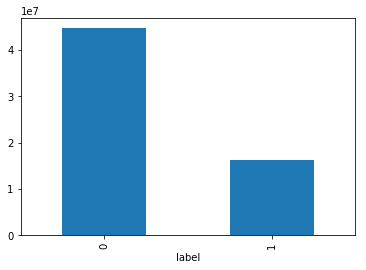

In [47]:
final.groupby('label')['num_of_char'].sum().plot(kind='bar');

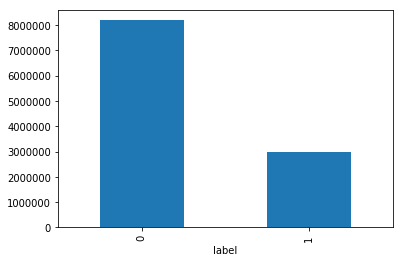

In [48]:
final.groupby('label')['num_of_words'].sum().plot(kind='bar');

Non-recommended reviews are generally shorter than recommended reviews both in words and characters. This could potentially be a feature to classify the reviews.

### Difficult words

Using Python library Textstat, we can find words used in reviews that are not common.

In [49]:
final['difficult_words']= [textstat.difficult_words(x) for x in final['review']]

### Average Character per word

In [50]:
final['avg_character_per_word']= [textstat.avg_character_per_word(x) for x in final['review']]

### Total syllables count of review

In [51]:
final['syllable_count']= [textstat.syllable_count(x) for x in final['review']]

### Average syllables per word

In [52]:
final['avg_syllables_per_word']= [textstat.avg_syllables_per_word(x) for x in final['review']]

### Total Sentence count of review

In [53]:
final['sentence_count']= [textstat.sentence_count(x) for x in final['review']]

### Average sentence length of review

In [54]:
final['avg_sentence_length']= [textstat.avg_sentence_length(x) for x in final['review']]

### Average sentence per word

In [55]:
final['avg_sentence_per_word']= [textstat.avg_sentence_per_word(x) for x in final['review']]

### Flesch reading ease

Flesch reading ease measures how complex a text is. The lower the score, the more difficult the text is to read.

In [56]:
final['flesch_reading_ease']= [textstat.flesch_reading_ease(x) for x in final['review']]

### Number of stopwords in review

In [57]:
stops = set(stopwords.words('english'))

In [58]:
def count_stopwords(text):
    words = text.split()
    words_list = []
    for word in words:
        if word in stops:
            words_list.append(word)
    return len(words_list)

In [59]:
final['num_of_stopwords'] = [count_stopwords(x) for x in final['review']]

### Number of numerics in review

In [60]:
def count_numerics(text):
    words = text.split()
    numerics = []
    for word in words:
        if word.isdigit():
            numerics.append(word)
    return len(numerics)   

In [61]:
final['num_of_numerics'] = [count_numerics(x) for x in final['review']]

### Number of unique words in review

In [62]:
final['num_of_unique_words'] = [len(set(row.split())) for row in final['review']]

### Number of Uppercase Characters

In [63]:
def count_upper(text):
    uppercase =[]
    for char in text:
        if char.isupper():
            uppercase.append(char)
    return len(uppercase)

In [64]:
final['num_of_uppercase_char'] = [count_upper(row) for row in final['review']]

### Ratio Uppercase Characters / Total Length of review by characters

In [65]:
final['ratio_of_uppercase_char'] = final['num_of_uppercase_char']/final['num_of_char']

In [117]:
print(final[final['label']==1]['ratio_of_uppercase_char'].mean())
print(final[final['label']==0]['ratio_of_uppercase_char'].mean())

0.03085828006858435
0.029250175976686273


### Ratio of difficult words / total words

In [66]:
final['ratio_of_difficult_words'] = final['difficult_words']/final['num_of_words']

### Ratio of unique words / total words

In [67]:
final['ratio_of_unique_words'] = final['num_of_unique_words']/final['num_of_words']

### Sentiment Analysis of review

Using Textblob, we can get sentiment analysis of each review. Textblob offers a score based on the polarity and subjectivity of the content.

In [68]:
#new columns created with textblob
final['polarity'] = [TextBlob(x).sentiment.polarity for x in final['review']]
final['subjectivity'] = [TextBlob(x).sentiment.subjectivity for x in final['review']]

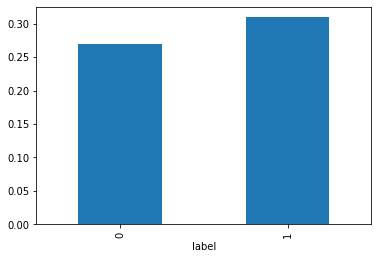

In [54]:
final.groupby('label')['polarity'].mean().plot(kind='bar')

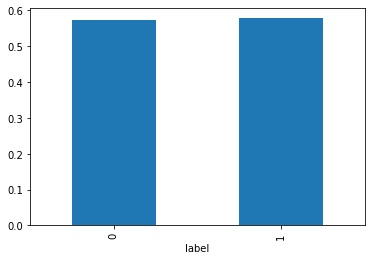

In [55]:
final.groupby('label')['subjectivity'].mean().plot(kind='bar')

Next we will also like to user vader's sentiment analyzer. This model gives a score based on the negative, neutral, positive and compound. 

In [69]:
#new columns created with vader sentiment analyzer
analyser = SentimentIntensityAnalyzer()
final['Negative'] = [analyser.polarity_scores(x)['neg'] for x in final['review']]
final['Neutral'] = [analyser.polarity_scores(x)['neu'] for x in final['review']]
final['Positive'] = [analyser.polarity_scores(x)['pos'] for x in final['review']]
final['Compound'] = [analyser.polarity_scores(x)['compound'] for x in final['review']]

In [119]:
print(final[final['label']==1]['Compound'].mean())
print(final[final['label']==0]['Compound'].mean())

0.6802719696147728
0.7751285387095423


### Parts of Speech (POS)

Using SpaCy, we can extract how each word is being used in the review. The list of POS is as follows:<br>
<br>
ADJ: adjective<br>
ADP: adposition<br>
ADV: adverb<br>
AUX: auxiliary verb<br>
CCONJ: coordinating conjunction<br>
DET: determiner<br>
INTJ: interjection<br>
NOUN: noun<br>
NUM: numeral<br>
PART: particle<br>
PRON: pronoun<br>
PROPN: proper noun<br>
PUNCT: punctuation<br>
SCONJ: subordinating conjunction<br>
SPACE: space<br>
SYM: symbol<br>
VERB: verb<br>
X: other

In [70]:
#load English multi-task CNN by spaCy
nlp = spacy.load("en_core_web_sm")

In [71]:
#store list of pos
listofpos=[]
for row in final['review']:
    doc = nlp(row)
    pos = []
    for token in doc:
        pos.append(token.pos_)
    listofpos.append(pos)

In [72]:
#new column created with all the pos for the particular review
final['pos'] = listofpos

In [73]:
#store all the pos
allpos=[]
for pos_list in listofpos:
    for pos in pos_list:
        allpos.append(pos)

In [74]:
#finding the unique pos
unique_elements, counts_elements = np.unique(allpos, return_counts=True)
unique_elements, counts_elements

(array(['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM',
        'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'VERB',
        'X'], dtype='<U5'),
 array([1113173,  944060,  890143,  875985,  538954, 1432100,   36634,
        2147554,  148502,  328269,  961499,  492188, 1616521,  219072,
         182525,   36685, 1301200,    9345], dtype=int64))

In [75]:
#new columns created with the count of each pos for each review
final['ADJ'] = [ x.count('ADJ') for x in final['pos']]
final['ADP'] = [ x.count('ADP') for x in final['pos']]
final['ADV'] = [ x.count('ADV') for x in final['pos']]
final['AUX'] = [ x.count('AUX') for x in final['pos']]
final['CCONJ'] = [ x.count('CCONJ') for x in final['pos']]
final['DET'] = [ x.count('DET') for x in final['pos']]
final['INTJ'] = [ x.count('INTJ') for x in final['pos']]
final['NOUN'] = [ x.count('NOUN') for x in final['pos']]
final['NUM'] = [ x.count('NUM') for x in final['pos']]
final['PART'] = [ x.count('PART') for x in final['pos']]
final['PRON'] = [ x.count('PRON') for x in final['pos']]
final['PROPN'] = [ x.count('PROPN') for x in final['pos']]
final['PUNCT'] = [ x.count('PUNCT') for x in final['pos']]
final['SCONJ'] = [ x.count('SCONJ') for x in final['pos']]
final['SPACE'] = [ x.count('SPACE') for x in final['pos']]
final['SYM'] = [ x.count('SYM') for x in final['pos']]
final['VERB'] = [ x.count('VERB') for x in final['pos']]
final['X'] = [ x.count('X') for x in final['pos']]

### Ratio of Noun / POS

In [76]:
#new columns created with the ratio of each pos for each review
final['Ratio_of_ADJ'] = final['ADJ']/final['num_of_words']
final['Ratio_of_ADP'] = final['ADP']/final['num_of_words']
final['Ratio_of_ADV'] = final['ADV']/final['num_of_words']
final['Ratio_of_AUX'] = final['AUX']/final['num_of_words']
final['Ratio_of_CCONJ'] = final['CCONJ']/final['num_of_words']
final['Ratio_of_DET'] = final['DET']/final['num_of_words']
final['Ratio_of_INTJ'] = final['INTJ']/final['num_of_words']
final['Ratio_of_NOUN'] = final['NOUN']/final['num_of_words']
final['Ratio_of_NUM'] = final['NUM']/final['num_of_words']
final['Ratio_of_PART'] = final['PART']/final['num_of_words']
final['Ratio_of_PRON'] = final['PRON']/final['num_of_words']
final['Ratio_of_PROPN'] = final['PROPN']/final['num_of_words']
final['Ratio_of_PUNCT'] = final['PUNCT']/final['num_of_words']
final['Ratio_of_SCONJ'] = final['SCONJ']/final['num_of_words']
final['Ratio_of_SPACE'] = final['SPACE']/final['num_of_words']
final['Ratio_of_SYM'] = final['SYM']/final['num_of_words']
final['Ratio_of_VERB'] = final['VERB']/final['num_of_words']
final['Ratio_of_X'] = final['X']/final['num_of_words']

In [118]:
print(final[final['label']==1]['Ratio_of_PUNCT'].mean())
print(final[final['label']==0]['Ratio_of_PUNCT'].mean())

0.16807413853921085
0.15931865942586743


#### Difference between user rating and restaurant average rating

In [77]:
#new column created for the difference between given rating and the average rating recevied by the restaurant
final['diff_in_rating'] =  final['rating'] - final['prod_avg_rating']

In [111]:
print(final[final['label']==1]['diff_in_rating'].mean())
print(final[final['label']==0]['diff_in_rating'].mean())

-0.05233669837925459
0.028142360971849457


## User's features

'user_lifetime', 'ratio_review_lifetime', 'avg_day_between_reviews',
       'mean_syllable_user', 'avg_rating_dev_res', 'ratio_review_timespan',
       'num_of_reviews', 'mean_num_words_user',
       'ratio_postive_rating_timespan', 'rating_dev', 'mean_readability_user',
       'diff_in_rating', 'polarity', 'num_of_four_rating', 'subjectivity',
       'ratio_of_uppercase_char', 'mean_num_sentence_user', 'Compound',
       'Ratio_of_PUNCT', 'ratio_same_day_lifetime'

In this section we are creating features engineered from the users itself. These features could give insights to how spam users are behaving and could be used for predictions.

In [106]:
#filter user features as a new dataframe
user_df_2015 = final[['user_id','date','year','rating','label']].sort_values(by=['user_id', 'date'])

In [107]:
#checking first 5 rows
user_df_2015.head()

,user_id,date,year,rating,label
289698,923,2013-11-04,2013,5.0,1
175032,923,2013-11-11,2013,5.0,1
237712,923,2013-11-19,2013,5.0,1
246545,923,2013-11-19,2013,5.0,1
73868,923,2013-11-27,2013,5.0,1


### Total number of posts for each user_id

Hwere I will like to know the total number of posts for each user_id.

In [108]:
#getting the total number of posts per user_id
num_of_reviews = pd.DataFrame(user_df_2015.groupby('user_id')['user_id'].count())

In [109]:
#storing the number of reviews per user_id in a list
user_reviews = []
for row in final['user_id']:
        user_reviews.append(num_of_reviews.loc[row, 'user_id'])

In [110]:
#new column with number of reviews for the user_id
final['num_of_reviews'] = user_reviews

### Number of ratings for each user_id

I will also like to know the total number of ratings per category given by each user_id.

In [111]:
#group and count the total ratings per user_id
table = pd.pivot_table(user_df_2015, values ='label', index=['user_id'], columns=['rating'], aggfunc='count')

In [112]:
#checking the first 5 row
table.head()

rating,1.0,2.0,3.0,4.0,5.0
user_id,,,,,
923,1.0,NaN,3.0,12.0,23.0
924,NaN,NaN,1.0,NaN,NaN
925,NaN,NaN,NaN,2.0,NaN
926,NaN,NaN,NaN,1.0,NaN
927,NaN,1.0,1.0,2.0,1.0


In [113]:
#creating new column - no. of 5 rating per user_id
five_rating = []
for row in final['user_id']:
        five_rating.append(table.loc[row, 5])
final['num_of_five_rating'] = five_rating

In [114]:
#creating new column - no. of 4 rating per user_id
four_rating = []
for row in final['user_id']:
        four_rating.append(table.loc[row, 4])
final['num_of_four_rating'] = four_rating

In [115]:
#creating new column - no. of 3 rating per user_id
three_rating = []
for row in final['user_id']:
        three_rating.append(table.loc[row, 3])
final['num_of_three_rating'] = three_rating

In [116]:
#creating new column - no. of 2 rating per user_id
two_rating = []
for row in final['user_id']:
        two_rating.append(table.loc[row, 2])
final['num_of_two_rating'] = two_rating

In [117]:
#creating new column - no. of 1 rating per user_id
one_rating = []
for row in final['user_id']:
        one_rating.append(table.loc[row, 1])
final['num_of_one_rating'] = one_rating

In [118]:
#fill Nan values with 0 as ther are 0 such rating given by the user_id
final.fillna(0,inplace=True)

### Average duration between each post for each user_id

I will like to know what is the duration between each review by each user_id. As the dataset only have the date, the difference will be in days.

In [119]:
#change the data type to datetime
user_df_2015['date'] = pd.to_datetime(user_df_2015['date'])

In [120]:
#create new column with the difference in days with the next row
user_df_2015['diff'] = user_df_2015['date'].diff()

In [121]:
#filtered out the first appearance of each user_id
user_df_2015_duplicate = user_df_2015[user_df_2015.duplicated('user_id')]

In [122]:
#extracting the days out of datetime fortmat and changing to int.
user_df_2015_duplicate['diff'] = user_df_2015_duplicate['diff'].apply(lambda x: x.days).astype('int64')

In [123]:
#groupby user_id and average the difference
diff = pd.DataFrame(user_df_2015_duplicate.groupby('user_id')['diff'].mean())

In [124]:
#storing all the average difference in a list
avg_day = []
for row in final['user_id']:
    try:
        avg_day.append(diff.loc[row, 'diff'])
    except:
        avg_day.append('0')

In [125]:
#new column created for the average difference between each review per user_id
final['avg_day_between_reviews'] = avg_day

In [126]:
#changing the data type to float
final['avg_day_between_reviews'] = final['avg_day_between_reviews'].astype('float64')

In [107]:
final[final['label']==0]['avg_day_between_reviews'].mean()

93.95164708152573

In [108]:
final[final['label']==1]['avg_day_between_reviews'].mean()

24.856449379692926

### Number of same day reviews for each user_id

I will also like to find out the number of same day reviews for each user_id.

In [127]:
#filtering same day review
user_same_day = user_df_2015[user_df_2015.duplicated(['user_id','date'])]

In [128]:
#counting the number of same day review per user_id
user_df_2015_duplicate_count = pd.DataFrame(user_same_day.groupby('user_id')['user_id'].count())

In [129]:
#storing the count in a list
same_day_review_count = []
for row in final['user_id']:
    try:
        same_day_review_count.append(user_df_2015_duplicate_count.loc[row, 'user_id'])
    except:
        same_day_review_count.append(0)

In [130]:
#new column created with the count of same day reviews.
final['same_day_review_count'] = same_day_review_count

### Lifetime of user_id (in days)

In [131]:
first_day_post = pd.DataFrame(user_df_2015.groupby('user_id').first()['date'])
last_day_post = pd.DataFrame(user_df_2015.groupby('user_id').last()['date'])

In [132]:
first_post = []
for row in final['user_id']:
        first_post.append(first_day_post.loc[row, 'date'])

In [133]:
final['first_date_post'] = first_post

In [134]:
last_post = []
for row in final['user_id']:
        last_post.append(last_day_post.loc[row, 'date'])

In [135]:
final['last_date_post'] = last_post

In [136]:
final['user_lifetime'] = final['last_date_post'] - final['first_date_post']

In [137]:
final['user_lifetime'] = [x.days for x in final['user_lifetime']]

In [138]:
final['user_lifetime'] = final['user_lifetime'] + 1

In [88]:
final[final['label']==0]['user_lifetime'].mean()

578.7756495353689

In [89]:
final[final['label']==1]['user_lifetime'].mean()

68.52289744981009

### Ratio of same day reviews for each user_id over Lifetime

In [139]:
final['ratio_same_day_lifetime'] = final['same_day_review_count'] / final['user_lifetime']

In [101]:
final[final['label']==0]['ratio_same_day_lifetime'].mean()

0.09903227374198562

In [7]:
final[final['label']==1]['ratio_same_day_lifetime'].mean()

0.18354876374969542

### Ratio of Same day reviews over Total reviews

In [21]:
final['ratio_same_day_totrv'] = final['same_day_review_count']/final['num_of_reviews']

In [102]:
final[final['label']==0]['ratio_same_day_totrv'].mean()

0.13662176336395696

In [8]:
final[final['label']==1]['ratio_same_day_totrv'].mean()

0.10365476785577826

### Ratio of Same day reviews over dataset timespan

The dataset timespan is 11 years

In [90]:
final['ratio_same_day_review_timespan'] = final['same_day_review_count']/11

### Mean number of words in reviews by user

In [140]:
mean_words_user = pd.DataFrame(final.groupby('user_id')['num_of_words'].mean())

In [141]:
mean_words = []
for row in final['user_id']:
        mean_words.append(mean_words_user.loc[row, 'num_of_words'])

In [142]:
final['mean_num_words_user'] = mean_words

In [115]:
print(final[final['label']==1]['mean_num_words_user'].mean())
print(final[final['label']==0]['mean_num_words_user'].mean())

81.0885201714764
119.52520308800068


### Mean number of sentence in reviews by user

In [143]:
mean_sentence_user = pd.DataFrame(final.groupby('user_id')['sentence_count'].mean())

In [144]:
mean_sentence = []
for row in final['user_id']:
        mean_sentence.append(mean_sentence_user.loc[row, 'sentence_count'])

In [145]:
final['mean_num_sentence_user'] = mean_sentence

In [116]:
print(final[final['label']==1]['mean_num_sentence_user'].mean())
print(final[final['label']==0]['mean_num_sentence_user'].mean())

4.344321676371804
6.268031670906209


### Mean readability of reviews by user

In [146]:
mean_readability_user = pd.DataFrame(final.groupby('user_id')['flesch_reading_ease'].mean())

In [147]:
mean_readability = []
for row in final['user_id']:
        mean_readability.append(mean_readability_user.loc[row, 'flesch_reading_ease'])

In [148]:
final['mean_readability_user'] = mean_readability

### Mean syllable of reviews by user

In [149]:
mean_syllable_user = pd.DataFrame(final.groupby('user_id')['syllable_count'].mean())

In [150]:
mean_syllable = []
for row in final['user_id']:
        mean_syllable.append(mean_syllable_user.loc[row, 'syllable_count'])

In [151]:
final['mean_syllable_user'] = mean_syllable

In [114]:
print(final[final['label']==1]['mean_syllable_user'].mean())
print(final[final['label']==0]['mean_syllable_user'].mean())

107.2366877300503
157.6047016042621


### Deviation of user's ratings

The deviation of ratings given a user_id.

In [152]:
rating_dev = pd.DataFrame(final.groupby('user_id')['rating'].std())

In [153]:
rating_dev.fillna(0,inplace=True)

In [154]:
rat_dev = []
for row in final['user_id']:
        rat_dev.append(rating_dev.loc[row, 'rating'])

In [155]:
final['rating_dev'] = rat_dev

### Average deviation of ratings from average ratings

The deviation of ratings from the restaurant's average rating given a user_id.

In [156]:
avg_rating_dev = pd.DataFrame(final.groupby('user_id')['diff_in_rating'].std())

In [157]:
avg_rating_dev.fillna(0,inplace=True)

In [158]:
avg_rat_dev = []
for row in final['user_id']:
        avg_rat_dev.append(avg_rating_dev.loc[row, 'diff_in_rating'])

In [159]:
final['avg_rating_dev_res'] = avg_rat_dev

### Max same day reviews

The maximum number of reviews posted on the same day given a user_id.

In [160]:
#filtering same day review
user_same_day = user_df_2015[user_df_2015.duplicated(['user_id','date'])]

In [161]:
#counting the number of same day review per user_id
user_df_2015_max_count = pd.DataFrame(user_same_day.groupby(['user_id','date']).size()).groupby('user_id').max()

In [162]:
#storing the count in a list
same_day_max_count = []
for row in final['user_id']:
    try:
        same_day_max_count.append(user_df_2015_max_count.loc[row,0])
    except:
        same_day_max_count.append(0)

In [163]:
#new column created with the count of same day reviews.
final['same_day_max_count'] = same_day_max_count

### Ratio of positive and negative ratings

Here we consider positive ratings as 4 and 5. Negative ratings as 1 and 2.

In [164]:
final['ratio_postive_rating'] = (final['num_of_five_rating'] + final['num_of_four_rating'])/final['num_of_reviews']
final['ratio_negative_rating'] = (final['num_of_one_rating'] + final['num_of_two_rating'])/final['num_of_reviews']

In [136]:
final['ratio_postive_rating_timespan'] = (final['num_of_five_rating'] + final['num_of_four_rating'])/11
final['ratio_negative_rating_timespan'] = (final['num_of_one_rating'] + final['num_of_two_rating'])/11

### Ratio of Total reviews over lifetime

In [165]:
final['ratio_review_lifetime'] = final['num_of_reviews']/final['user_lifetime']

In [105]:
final[final['label']==0]['ratio_review_lifetime'].mean()

0.43377704094740777

In [106]:
final[final['label']==1]['ratio_review_lifetime'].mean()

0.968026956270519

### Ratio of Total reviews over dataset timespan

In [23]:
final['ratio_review_timespan'] = final['num_of_reviews']/11

### Clustering of users

In [137]:
users = final.groupby('user_id').first()

In [139]:
users = users[['num_of_reviews','avg_day_between_reviews', 'user_lifetime', 'same_day_max_count',
       'ratio_review_timespan', 'ratio_same_day_review_timespan','ratio_postive_rating_timespan','ratio_negative_rating_timespan']]

In [140]:
ss = StandardScaler()
users_sc = ss.fit_transform(users)

In [141]:
km = KMeans(n_clusters=5)
km.fit(users_sc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [142]:
users['cluster'] = km.labels_

In [158]:
user_cluster = []
for user in final['user_id']:
    user_cluster.append(users.loc[user,'cluster'])

In [159]:
final['cluster'] = user_cluster

# Get Dummies for Ratings

Ratings are considered categorical since we are predicting whether the review is spam or ham.

In [25]:
final = pd.get_dummies(final, columns = ['rating'])

# Saving to CSV

In [113]:
# final.to_csv('./datasets/final_nyc_dummies.csv')

In [3]:
final = pd.read_csv('./datasets/final_nyc_dummies.csv')

In [4]:
final = final.drop(columns = 'Unnamed: 0')

In [5]:
final.head()

,user_id,prod_id,label,date,review,month,year,prod_avg_rating,num_of_char,num_of_words,difficult_words,avg_character_per_word,syllable_count,avg_syllables_per_word,sentence_count,avg_sentence_length,avg_sentence_per_word,flesch_reading_ease,num_of_stopwords,num_of_numerics,num_of_unique_words,num_of_uppercase_char,ratio_of_uppercase_char,ratio_of_difficult_words,ratio_of_unique_words,polarity,subjectivity,Negative,Neutral,Positive,Compound,pos,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SPACE,SYM,VERB,X,Ratio_of_ADJ,Ratio_of_ADP,Ratio_of_ADV,Ratio_of_AUX,Ratio_of_CCONJ,Ratio_of_DET,Ratio_of_INTJ,Ratio_of_NOUN,Ratio_of_NUM,Ratio_of_PART,Ratio_of_PRON,Ratio_of_PROPN,Ratio_of_PUNCT,Ratio_of_SCONJ,Ratio_of_SPACE,Ratio_of_SYM,Ratio_of_VERB,Ratio_of_X,diff_in_rating,num_of_reviews,num_of_five_rating,num_of_four_rating,num_of_three_rating,num_of_two_rating,num_of_one_rating,avg_day_between_reviews,same_day_review_count,first_date_post,last_date_post,user_lifetime,ratio_same_day_lifetime,mean_num_words_user,mean_num_sentence_user,mean_readability_user,mean_syllable_user,rating_dev,avg_rating_dev_res,same_day_max_count,ratio_postive_rating,ratio_negative_rating,ratio_review_lifetime,ratio_same_day_totrv,ratio_review_timespan,rating_1.0,rating_2.0,rating_3.0,rating_4.0,rating_5.0,ratio_same_day_review_timespan,ratio_postive_rating_timespan,ratio_negative_rating_timespan,cluster
0,923,0,1,2014-12-08,The food at snack is a selection of popular Gr...,12,2014,3.854839,215,40,8,4.40,55,1.4,4,10.0,0.10,78.25,16,0,35,6,0.027907,0.200000,0.875000,0.195833,0.395833,0.038,0.830,0.131,0.6170,"['DET', 'NOUN', 'ADP', 'NOUN', 'AUX', 'DET', '...",6,3,2,7,0,5,0,9,2,1,3,0,4,2,0,1,2,0,0.150000,0.075000,0.050000,0.175000,0.000000,0.125000,0.0,0.225000,0.050000,0.025000,0.075000,0.000000,0.100000,0.050000,0.000000,0.025,0.050000,0.0,-0.854839,39,23.0,12.0,3.0,0.0,1.0,10.50,15,2013-11-04,2014-12-08,400,0.0375,63.717949,4.846154,80.006154,84.717949,0.852083,0.864591,2,0.897436,0.025641,0.097500,0.384615,3.545455,0,0,1,0,0,1.363636,3.181818,0.090909,2
1,924,0,1,2013-05-16,This little place in Soho is wonderful. I had ...,5,2013,3.854839,269,52,3,4.19,64,1.2,4,13.0,0.08,92.12,24,0,43,6,0.022305,0.057692,0.826923,0.025000,0.650000,0.092,0.768,0.140,0.5783,"['DET', 'ADJ', 'NOUN', 'ADP', 'PROPN', 'AUX', ...",7,3,4,7,4,9,0,11,0,1,2,2,9,0,0,0,4,0,0.134615,0.057692,0.076923,0.134615,0.076923,0.173077,0.0,0.211538,0.000000,0.019231,0.038462,0.038462,0.173077,0.000000,0.000000,0.000,0.076923,0.0,-0.854839,1,0.0,0.0,1.0,0.0,0.0,0.00,0,2013-05-16,2013-05-16,1,0.0000,52.000000,4.000000,92.120000,64.000000,0.000000,0.000000,0,0.000000,0.000000,1.000000,0.000000,0.090909,0,0,1,0,0,0.000000,0.000000,0.000000,0
2,925,0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,7,2013,3.854839,178,32,4,4.59,43,1.3,1,32.0,0.03,64.38,11,1,30,4,0.022472,0.125000,0.937500,0.220000,0.328718,0.000,0.751,0.249,0.8515,"['VERB', 'NOUN', 'ADP', 'NUM', 'ADP', 'PROPN',...",4,4,0,2,1,3,0,7,1,0,4,2,5,1,2,0,3,0,0.125000,0.125000,0.000000,0.062500,0.031250,0.093750,0.0,0.218750,0.031250,0.000000,0.125000,0.062500,0.156250,0.031250,0.062500,0.000,0.093750,0.0,0.145161,2,0.0,2.0,0.0,0.0,0.0,0.00,1,2013-07-01,2013-07-01,1,1.0000,36.500000,2.000000,77.895000,45.500000,0.000000,0.060283,1,1.000000,0.000000,2.000000,0.500000,0.181818,0,0,0,1,0,0.090909,0.181818,0.000000,1
3,926,0,1,2011-07-28,This is a beautiful quaint little restaurant o...,7,2011,3.854839,491,90,9,4.57,114,1.3,5,17.6,0.06,78.99,37,0,68,8,0.016293,0.100000,0.755556,0.555134,0.776786,0.022,0.706,0.272,0.9779,"['DET', 'AUX', 'DET', 'ADJ', 'NOUN', 'ADJ', 'N...",10,9,2,8,4,16,0,18,1,2,8,2,12,3,2,0,7,0,0.111111,0.100000,0.022222,0.088889,0.044444,0.177778,0.0,0.200000,0.011111,0.022222,0.088889,0.022222,0.133333,0.033333,0.022222,0.000,0.077778,0.0,0.145161,1,0.0,1.0,0.0,0.0,0.0,0.00,0,2011-07-28,2011-07-28,1,0.0000,90.000000,5.000000,78.990000,114.000000,0.000000,0.000000,0,1.000000,0.000000,1.000000,0.0000

# Train Test Split

We will random split our dataset into training (80%) and testing set(20%).

In [9]:
# features for our predictions
features = ['review', 'prod_avg_rating', 'num_of_char', 'num_of_words', 'difficult_words',
       'avg_character_per_word', 'syllable_count', 'avg_syllables_per_word',
       'sentence_count', 'avg_sentence_length', 'avg_sentence_per_word',
       'flesch_reading_ease', 'num_of_stopwords', 'num_of_numerics',
       'num_of_unique_words', 'num_of_uppercase_char',
       'ratio_of_uppercase_char', 'ratio_of_difficult_words',
       'ratio_of_unique_words', 'polarity', 'subjectivity', 'Negative',
       'Neutral', 'Positive', 'Compound', 'ADJ', 'ADP', 'ADV', 'AUX',
       'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT',
       'SCONJ', 'SPACE', 'SYM', 'VERB', 'X', 'Ratio_of_ADJ', 'Ratio_of_ADP',
       'Ratio_of_ADV', 'Ratio_of_AUX', 'Ratio_of_CCONJ', 'Ratio_of_DET',
       'Ratio_of_INTJ', 'Ratio_of_NOUN', 'Ratio_of_NUM', 'Ratio_of_PART',
       'Ratio_of_PRON', 'Ratio_of_PROPN', 'Ratio_of_PUNCT', 'Ratio_of_SCONJ',
       'Ratio_of_SPACE', 'Ratio_of_SYM', 'Ratio_of_VERB', 'Ratio_of_X',
       'diff_in_rating', 'num_of_reviews', 'num_of_five_rating',
       'num_of_four_rating', 'num_of_three_rating', 'num_of_two_rating',
       'num_of_one_rating', 'avg_day_between_reviews', 'same_day_review_count', 'user_lifetime',
       'ratio_same_day_lifetime', 'mean_num_words_user',
       'mean_num_sentence_user', 'mean_readability_user', 'mean_syllable_user',
       'rating_dev', 'avg_rating_dev_res', 'same_day_max_count',
       'ratio_postive_rating', 'ratio_negative_rating',
       'ratio_review_lifetime', 'ratio_same_day_totrv',
       'ratio_review_timespan', 'rating_1.0', 'rating_2.0', 'rating_3.0',
       'rating_4.0', 'rating_5.0','ratio_same_day_review_timespan',
       'ratio_postive_rating_timespan', 'ratio_negative_rating_timespan',
       'cluster']
X = final[features] 
y = final['label'] #spam or ham class

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

# Modelling

In this section I will explain the approaches that I had taken to classify the reviews.

## Baseline Model Accuracy

In [7]:
final['label'].value_counts(normalize=True)

0    0.650314
1    0.349686
Name: label, dtype: float64

There are 65% recommended reviews and 35% non-recommended reviews.

## Predictions using review Text only

There could be some words that spam users uses often and the review text itself could be useful to classify the reviews into spam or ham. Hence the first approach is to build a model and try to classify each review.

In [25]:
lemmatizer = WordNetLemmatizer() #instantiate model

In [26]:
def review_to_words(content):
    # Function to convert a raw review to a string of words
    # The input is a single string (title + main body post), and 
    # the output is a single string (a preprocessed title + main body post)
    
    # 1. Remove non-alphanumeric and \n
    letters_only = re.sub("[^a-zA-Z]", " ", str(content)).replace('\n', ' ')
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 4. Remove stop words, lemmatize and stem words
    meaningful_words = [lemmatizer.lemmatize(w) for w in words if not w in stops]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [27]:
clean_train = [] #training set 
clean_test = [] #testing set

In [28]:
for data in X_train['review']:
    # Convert review to words, then append to clean_train_title.
    clean_train.append(review_to_words(data))

for data in X_test['review']:
    # Convert review to words, then append to clean_test_title.
    clean_test.append(review_to_words(data))

In [29]:
tvec = TfidfVectorizer(max_features=3000, ngram_range=(1, 5)) #instantiate model

In [30]:
train_data_tvec = tvec.fit_transform(clean_train).todense() #todense makes storing sparse matrix more efficiently
test_data_tvec = tvec.transform(clean_test).todense() #todense makes storing sparse matrix more efficiently

In [17]:
ss = StandardScaler() #instantiate model
train_sc = ss.fit_transform(train_data_tvec) #scaling our train features
test_sc = ss.transform(test_data_tvec) #scaling our test features

I will be using logistic regression, random forest classifier and extra trees classifier make predictions.

In [18]:
lr=LogisticRegression(C=0.00001) #instantiate model
lr.fit(train_sc, y_train)
print(lr.score(train_sc, y_train))
print(lr.score(test_sc, y_test))

0.6817825339000202
0.6643645884719007


In [20]:
rt = RandomForestClassifier(n_estimators=1000, max_depth=50, n_jobs=-1, class_weight={0:1, 1:2}) #instantiate model
rt.fit(train_sc, y_train)
print(rt.score(train_sc, y_train))
print(rt.score(test_sc, y_test))

0.9130363286784052
0.6591659393617425


In [21]:
et = ExtraTreesClassifier(n_estimators=1000, max_depth=50, n_jobs=-1, class_weight={0:2, 1:2}) #instantiate model
et.fit(train_sc, y_train)
print(et.score(train_sc, y_train))
print(et.score(test_sc, y_test))

0.6762548067192876
0.6505900656471749


In [22]:
y_train.value_counts(normalize=True)

0    0.650311
1    0.349689
Name: label, dtype: float64

In [23]:
y_test.value_counts(normalize=True)

0    0.650324
1    0.349676
Name: label, dtype: float64

As we can see from the above results, the accuracy is about the same as the baseline accuracy.

In [ ]:
predictions = lr.predict(test_sc) 

In [25]:
cm=confusion_matrix(y_test, predictions)

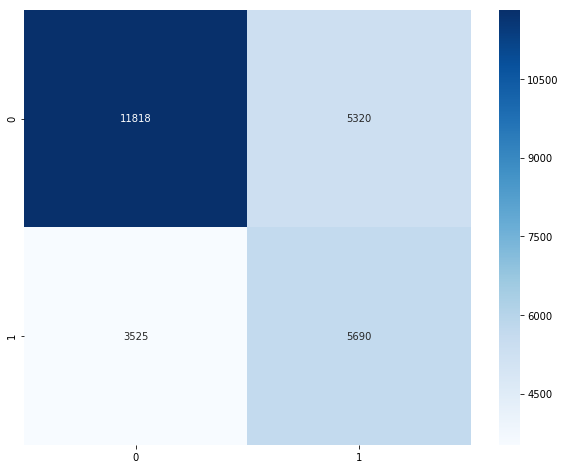

In [26]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot = True,cmap = 'Blues', fmt='g')

3525 spam are misclassified as ham, while 5320 ham are predicted to be as spam. 

In [27]:
tn, fp, fn, tp=confusion_matrix(y_test, predictions).ravel()

print(f'Accuracy = {round((tp + tn) /(tn+ fp+ fn+ tp),3)}')
print(f'Misclassification Rate = {round((fp + fn) /(tn+ fp+ fn+ tp),3)}')
print(f'Sensitivity = {round(tp /(fn+ tp),3)}')
print(f'Specificity = {round(tn /(fp+ tn),3)}')
print(f'Precision = {round(tp /(fp+ tp),3)}')

print(classification_report(y_test, predictions, target_names=['0','1']))

pred_proba = [i[1] for i in lr.predict_proba(test_sc)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

print(roc_auc_score(y_test,pred_proba))

Accuracy = 0.664
Misclassification Rate = 0.336
Sensitivity = 0.617
Specificity = 0.69
Precision = 0.517
             precision    recall  f1-score   support

          0       0.77      0.69      0.73     17138
          1       0.52      0.62      0.56      9215

avg / total       0.68      0.66      0.67     26353

0.713370835337692


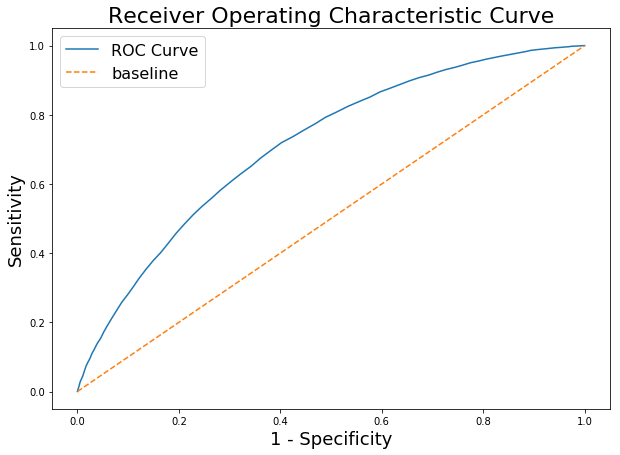

In [28]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_nb_cvec = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_nb_cvec = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values_nb_cvec, # False Positive Rate on X-axis
         tpr_values_nb_cvec, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

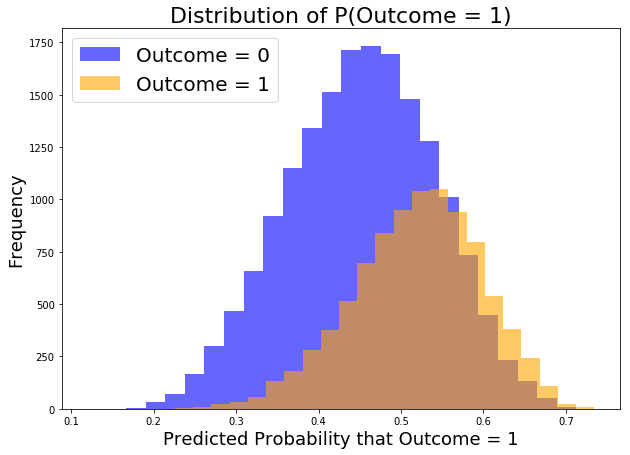

In [29]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

From the above we can see that using the text from the review, the model is not able to differentiate which reviews are spam and which are genuine reviews.<br>
<br>
Hence we can conclude the review text are not enough to make predictions for spam/fake reviews. 

## Predictions using review features only

In this section, I will use the features generated from reviews to classify if a review is spam/fake. 

In [17]:
review_features = ['num_of_char', 'num_of_words', 'difficult_words',
       'avg_character_per_word', 'syllable_count', 'avg_syllables_per_word',
       'sentence_count', 'avg_sentence_length', 'avg_sentence_per_word',
       'flesch_reading_ease', 'num_of_stopwords', 'num_of_numerics',
       'num_of_unique_words', 'num_of_uppercase_char',
       'ratio_of_uppercase_char', 'ratio_of_difficult_words',
       'ratio_of_unique_words', 'polarity', 'subjectivity', 'Negative',
       'Neutral', 'Positive', 'Compound', 'ADJ', 'ADP', 'ADV', 'AUX',
       'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT',
       'SCONJ', 'SPACE', 'SYM', 'VERB', 'X', 'Ratio_of_ADJ', 'Ratio_of_ADP',
       'Ratio_of_ADV', 'Ratio_of_AUX', 'Ratio_of_CCONJ', 'Ratio_of_DET',
       'Ratio_of_INTJ', 'Ratio_of_NOUN', 'Ratio_of_NUM', 'Ratio_of_PART',
       'Ratio_of_PRON', 'Ratio_of_PROPN', 'Ratio_of_PUNCT', 'Ratio_of_SCONJ',
       'Ratio_of_SPACE', 'Ratio_of_SYM', 'Ratio_of_VERB', 'Ratio_of_X',
       'diff_in_rating']

In [14]:
ss = StandardScaler() #instantiate model
train_review_sc = ss.fit_transform(X_train[review_features]) #scaling our train features
test_review_sc = ss.transform(X_test[review_features]) #scaling our test features

In [15]:
lr=LogisticRegression(C=0.00001) #instantiate model
lr.fit(train_review_sc, y_train)
print(lr.score(train_review_sc, y_train))
print(lr.score(test_review_sc, y_test))

0.6152474195506983
0.6156414829431184


In [40]:
rt = RandomForestClassifier(n_estimators=500, max_depth=50, n_jobs=-1, class_weight={0:1, 1:2}) #instantiate model
rt.fit(train_review_sc, y_train)
print(rt.score(train_review_sc, y_train))
print(rt.score(test_review_sc, y_test))

0.9997090669904878
0.6740029598148218


In [17]:
et = ExtraTreesClassifier(n_estimators=500, max_depth=50, n_jobs=-1, class_weight={0:2, 1:2}) #instantiate model
et.fit(train_review_sc, y_train)
print(et.score(train_review_sc, y_train))
print(et.score(test_review_sc, y_test))

0.9997090669904878
0.6730922475619474


We can see from the above results the accuracy is about the same as our baseline accuracy. 

In [18]:
review_predictions = rt.predict(test_review_sc)

In [19]:
cm=confusion_matrix(y_test, review_predictions)

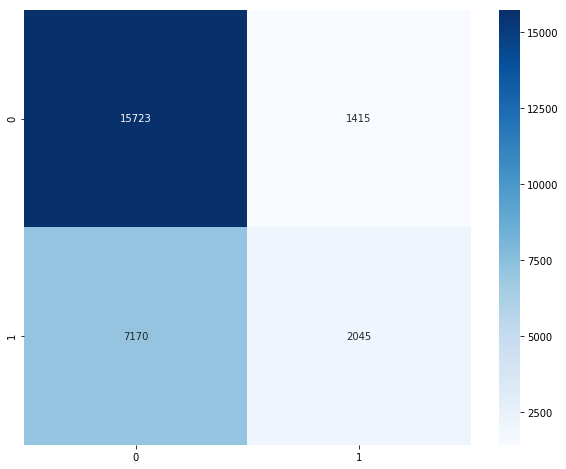

In [20]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot = True,cmap = 'Blues', fmt='g')

7170 spam are misclassified as ham, while 1415 ham are predicted to be as spam. 

In [21]:
tn, fp, fn, tp=confusion_matrix(y_test, review_predictions).ravel()

print(f'Accuracy = {round((tp + tn) /(tn+ fp+ fn+ tp),3)}')
print(f'Misclassification Rate = {round((fp + fn) /(tn+ fp+ fn+ tp),3)}')
print(f'Sensitivity = {round(tp /(fn+ tp),3)}')
print(f'Specificity = {round(tn /(fp+ tn),3)}')
print(f'Precision = {round(tp /(fp+ tp),3)}')

print(classification_report(y_test, review_predictions, target_names=['0','1']))

pred_proba = [i[1] for i in rt.predict_proba(test_review_sc)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

print(roc_auc_score(y_test,pred_proba))

Accuracy = 0.674
Misclassification Rate = 0.326
Sensitivity = 0.222
Specificity = 0.917
Precision = 0.591
             precision    recall  f1-score   support

          0       0.69      0.92      0.79     17138
          1       0.59      0.22      0.32      9215

avg / total       0.65      0.67      0.62     26353

0.6876802410891081


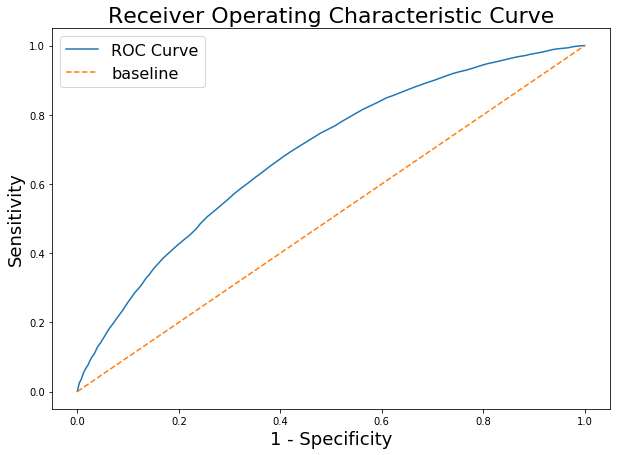

In [22]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_nb_cvec = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_nb_cvec = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values_nb_cvec, # False Positive Rate on X-axis
         tpr_values_nb_cvec, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

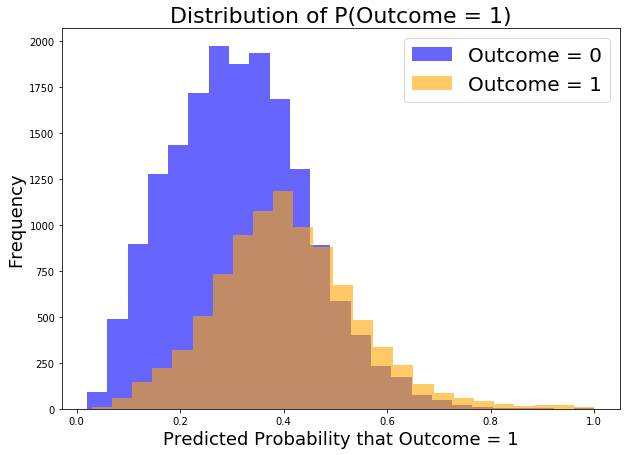

In [23]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

The ROC score for using review features only is lower than using review text itself. More ham are predicted correctly but more spam are misclassified.<br>
<br>
Overall, we can conclude that both review features and review text alone are not good predictors of spam/fake reviews.

## Predictions using users features only

In this section, I will build a classifier based on the users features to predict if a review is spam/fake.

In [31]:
user_features = ['num_of_reviews', 'num_of_five_rating',
       'num_of_four_rating', 'num_of_three_rating', 'num_of_two_rating',
       'num_of_one_rating', 'avg_day_between_reviews', 'same_day_review_count', 'user_lifetime',
       'ratio_same_day_lifetime', 'mean_num_words_user',
       'mean_num_sentence_user', 'mean_readability_user', 'mean_syllable_user',
       'rating_dev', 'avg_rating_dev_res', 'same_day_max_count',
       'ratio_postive_rating', 'ratio_negative_rating',
       'ratio_review_lifetime', 'ratio_same_day_totrv',
       'ratio_review_timespan','ratio_same_day_review_timespan',
       'ratio_postive_rating_timespan', 'ratio_negative_rating_timespan']

In [19]:
ss = StandardScaler()
train_user_sc = ss.fit_transform(X_train[user_features])
test_user_sc = ss.transform(X_test[user_features])

In [20]:
lr=LogisticRegression() 
lr.fit(train_user_sc, y_train)
print(lr.score(train_user_sc, y_train))
print(lr.score(test_user_sc, y_test))

0.7313929366524995
0.7242059727545251


In [21]:
rt = RandomForestClassifier(max_depth=60,n_estimators=550, n_jobs=-1, class_weight={0:1, 1:2}) 
rt.fit(train_user_sc, y_train)
print(rt.score(train_user_sc, y_train))
print(rt.score(test_user_sc, y_test))

0.9612806112123052
0.8042348119758661


In [22]:
et = ExtraTreesClassifier(n_estimators=550, max_depth=50, n_jobs=-1,class_weight={0:1, 1:2})
et.fit(train_user_sc, y_train)
print(et.score(train_user_sc, y_train))
print(et.score(test_user_sc, y_test))

0.9599018417324429
0.8016165142488522


From the results above, we can see that the accuracy had improve upon using the user features.

In [32]:
user_predictions = rt.predict(test_user_sc)

In [33]:
cm=confusion_matrix(y_test, user_predictions)

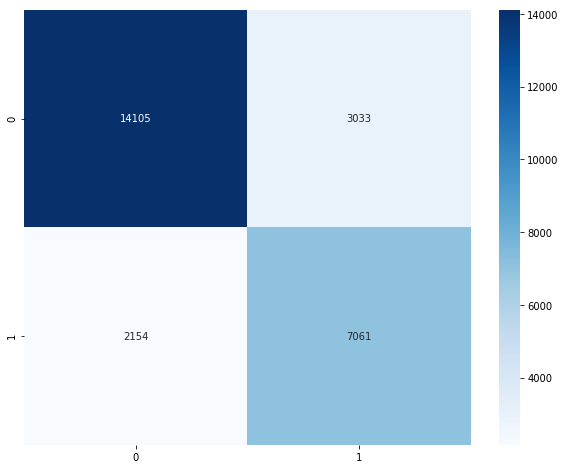

In [34]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot = True,cmap = 'Blues', fmt='g')

2154 spam are misclassified as ham, while 3033 ham are predicted to be as spam. 

In [35]:
tn, fp, fn, tp=confusion_matrix(y_test, user_predictions).ravel()

print(f'Accuracy = {round((tp + tn) /(tn+ fp+ fn+ tp),3)}')
print(f'Misclassification Rate = {round((fp + fn) /(tn+ fp+ fn+ tp),3)}')
print(f'Sensitivity = {round(tp /(fn+ tp),3)}')
print(f'Specificity = {round(tn /(fp+ tn),3)}')
print(f'Precision = {round(tp /(fp+ tp),3)}')

print(classification_report(y_test, user_predictions, target_names=['0','1']))

pred_proba = [i[1] for i in rt.predict_proba(test_user_sc)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

print(roc_auc_score(y_test,pred_proba))

Accuracy = 0.803
Misclassification Rate = 0.197
Sensitivity = 0.766
Specificity = 0.823
Precision = 0.7
             precision    recall  f1-score   support

          0       0.87      0.82      0.84     17138
          1       0.70      0.77      0.73      9215

avg / total       0.81      0.80      0.81     26353

0.8877505205422238


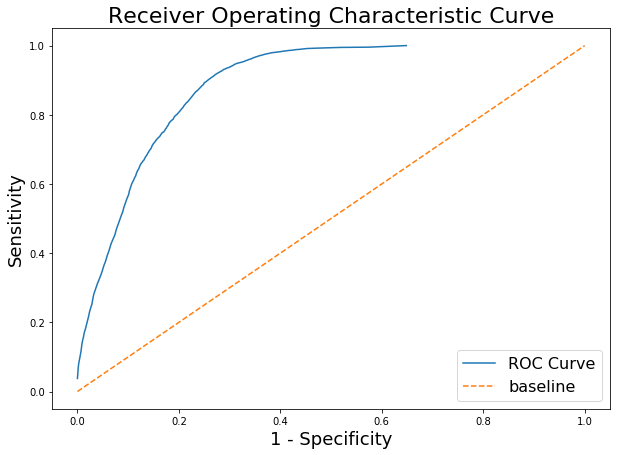

In [36]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_nb_cvec = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_nb_cvec = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values_nb_cvec, # False Positive Rate on X-axis
         tpr_values_nb_cvec, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

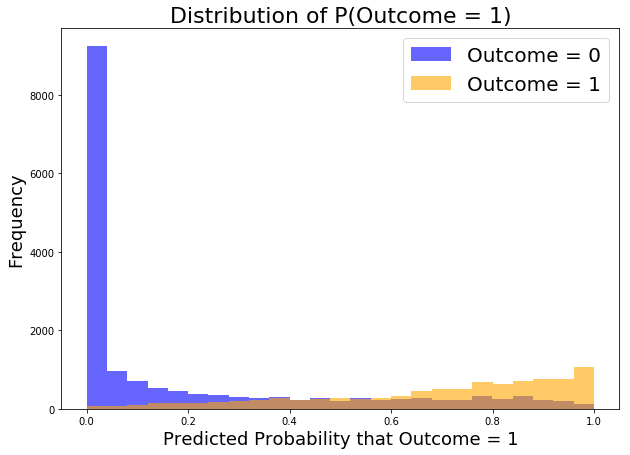

In [37]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

ROC score had improve to 0.89. There is lesser missclassfications as compared to the model using review text and review features.<br>
<br>
User's features are generally a good predictor for spam/fake review. Genuine and spam users may have distinct behavior and hence features engineered from the users can explain the variance. <br>
<br>
From the above distribution, at theshold 0.5, there is still some overlapping of class 0 and 1.

## Predictions using users features and review text only

In this section, I will build a classifier based on the users features along with the review text to predict if a review is spam/fake.

In [18]:
user_features = ['num_of_reviews', 'num_of_five_rating',
       'num_of_four_rating', 'num_of_three_rating', 'num_of_two_rating',
       'num_of_one_rating', 'avg_day_between_reviews', 'same_day_review_count', 'user_lifetime',
       'ratio_same_day_lifetime', 'mean_num_words_user',
       'mean_num_sentence_user', 'mean_readability_user', 'mean_syllable_user',
       'rating_dev', 'avg_rating_dev_res', 'same_day_max_count',
       'ratio_postive_rating', 'ratio_negative_rating',
       'ratio_review_lifetime', 'ratio_same_day_totrv',
       'ratio_review_timespan','ratio_same_day_review_timespan',
       'ratio_postive_rating_timespan', 'ratio_negative_rating_timespan']

In [32]:
train_user_text = np.hstack((X_train[user_features],train_data_tvec))
test_user_text = np.hstack((X_test[user_features],test_data_tvec))

In [33]:
ss = StandardScaler()
train_user_sc = ss.fit_transform(train_user_text)
test_user_sc = ss.transform(test_user_text)

In [34]:
lr=LogisticRegression() 
lr.fit(train_user_sc, y_train)
print(lr.score(train_user_sc, y_train))
print(lr.score(test_user_sc, y_test))

0.7766393442622951
0.7406746859940044


In [35]:
rt = RandomForestClassifier(max_depth=60,n_estimators=550, n_jobs=-1, class_weight={0:1, 1:2}) 
rt.fit(train_user_sc, y_train)
print(rt.score(train_user_sc, y_train))
print(rt.score(test_user_sc, y_test))

0.9304543614652905
0.754335369787121


In [36]:
et = ExtraTreesClassifier(n_estimators=550, max_depth=50, n_jobs=-1,class_weight={0:1, 1:2})
et.fit(train_user_sc, y_train)
print(et.score(train_user_sc, y_train))
print(et.score(test_user_sc, y_test))

0.8842972070431087
0.7409403104010929


From the results above, we can see that the accuracy had improve upon using the user features.

In [37]:
user_predictions = rt.predict(test_user_sc)

In [38]:
cm=confusion_matrix(y_test, user_predictions)

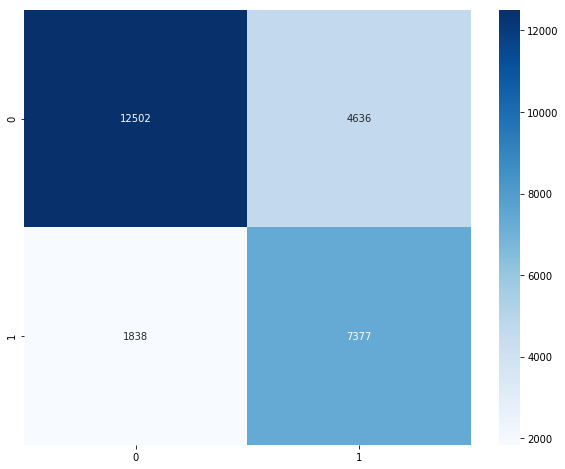

In [39]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot = True,cmap = 'Blues', fmt='g')

2154 spam are misclassified as ham, while 3033 ham are predicted to be as spam. 

In [40]:
tn, fp, fn, tp=confusion_matrix(y_test, user_predictions).ravel()

print(f'Accuracy = {round((tp + tn) /(tn+ fp+ fn+ tp),3)}')
print(f'Misclassification Rate = {round((fp + fn) /(tn+ fp+ fn+ tp),3)}')
print(f'Sensitivity = {round(tp /(fn+ tp),3)}')
print(f'Specificity = {round(tn /(fp+ tn),3)}')
print(f'Precision = {round(tp /(fp+ tp),3)}')

print(classification_report(y_test, user_predictions, target_names=['0','1']))

pred_proba = [i[1] for i in rt.predict_proba(test_user_sc)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

print(roc_auc_score(y_test,pred_proba))

Accuracy = 0.754
Misclassification Rate = 0.246
Sensitivity = 0.801
Specificity = 0.729
Precision = 0.614
             precision    recall  f1-score   support

          0       0.87      0.73      0.79     17138
          1       0.61      0.80      0.70      9215

avg / total       0.78      0.75      0.76     26353

0.8377892790369099


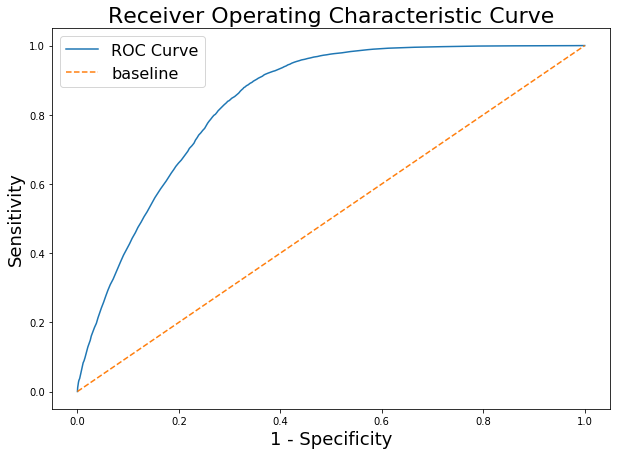

In [41]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_nb_cvec = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_nb_cvec = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values_nb_cvec, # False Positive Rate on X-axis
         tpr_values_nb_cvec, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

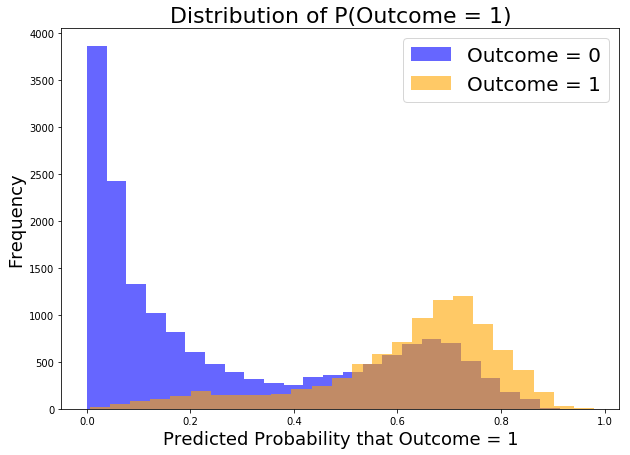

In [42]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

ROC score had dropped to 0.84. User's features are generally a good predictor for spam/fake review. However a model that based on the text may be easily reverse engineered and spammers can come up with a work around easily. 

## Predictions using reviews and user features only

Next I will like to see if using reviews and users features together can achieve higher accuracy and less misclassifications.<br>

In [70]:
user_review_features = ['num_of_char', 'num_of_words', 'difficult_words',
       'avg_character_per_word', 'syllable_count', 'avg_syllables_per_word',
       'sentence_count', 'avg_sentence_length', 'avg_sentence_per_word',
       'flesch_reading_ease', 'num_of_stopwords', 'num_of_numerics',
       'num_of_unique_words', 'num_of_uppercase_char',
       'ratio_of_uppercase_char', 'ratio_of_difficult_words',
       'ratio_of_unique_words', 'polarity', 'subjectivity', 'Negative',
       'Neutral', 'Positive', 'Compound', 'ADJ', 'ADP', 'ADV', 'AUX',
       'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT',
       'SCONJ', 'SPACE', 'SYM', 'VERB', 'X', 'Ratio_of_ADJ', 'Ratio_of_ADP',
       'Ratio_of_ADV', 'Ratio_of_AUX', 'Ratio_of_CCONJ', 'Ratio_of_DET',
       'Ratio_of_INTJ', 'Ratio_of_NOUN', 'Ratio_of_NUM', 'Ratio_of_PART',
       'Ratio_of_PRON', 'Ratio_of_PROPN', 'Ratio_of_SCONJ',
       'Ratio_of_SPACE', 'Ratio_of_SYM', 'Ratio_of_VERB', 'Ratio_of_X', 'Ratio_of_PUNCT',
       'diff_in_rating', 'num_of_reviews', 'num_of_five_rating',
       'num_of_four_rating', 'num_of_three_rating', 'num_of_two_rating',
       'num_of_one_rating', 'avg_day_between_reviews', 'same_day_review_count', 'user_lifetime',
       'ratio_same_day_lifetime', 'mean_num_words_user',
       'mean_num_sentence_user', 'mean_readability_user', 'mean_syllable_user',
       'rating_dev', 'avg_rating_dev_res', 'same_day_max_count',
       'ratio_postive_rating', 'ratio_negative_rating',
       'ratio_review_lifetime', 'ratio_same_day_totrv',
       'ratio_review_timespan', 'rating_1.0', 'rating_2.0', 'rating_3.0',
       'rating_4.0', 'rating_5.0','ratio_same_day_review_timespan',
       'ratio_postive_rating_timespan', 'ratio_negative_rating_timespan']

In [71]:
ss = StandardScaler()
train_review_user_sc = ss.fit_transform(X_train[user_review_features])
test_review_user_sc = ss.transform(X_test[user_review_features])

In [25]:
lr=LogisticRegression() 
lr.fit(train_review_user_sc, y_train)
print(lr.score(train_review_user_sc, y_train))
print(lr.score(test_review_user_sc, y_test))

0.7386409633677393
0.7319470269039579


In [72]:
rt = RandomForestClassifier(max_depth=50,n_estimators=550, n_jobs=-1, class_weight={0:1, 1:2}) 
rt.fit(train_review_user_sc, y_train)
print(rt.score(train_review_user_sc, y_train))
print(rt.score(test_review_user_sc, y_test))

0.9999494029548675
0.7544871551626001


In [48]:
et = ExtraTreesClassifier(n_estimators=550, max_depth=40, n_jobs=-1,class_weight={0:1, 1:2})
et.fit(train_review_user_sc, y_train)
print(et.score(train_review_user_sc, y_train))
print(et.score(test_review_user_sc, y_test))

0.9999494029548675
0.7512996622775395


In [73]:
cm=confusion_matrix(y_test, rt.predict(test_review_user_sc))

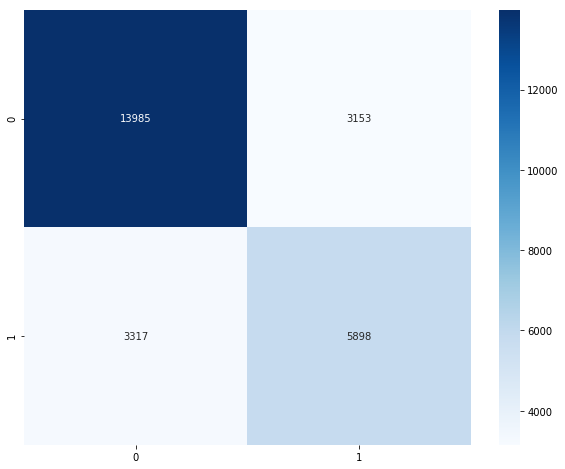

In [74]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot = True,cmap = 'Blues', fmt='g')

In [75]:
tn, fp, fn, tp=confusion_matrix(y_test, rt.predict(test_review_user_sc)).ravel()

print(f'Accuracy = {round((tp + tn) /(tn+ fp+ fn+ tp),3)}')
print(f'Misclassification Rate = {round((fp + fn) /(tn+ fp+ fn+ tp),3)}')
print(f'Sensitivity = {round(tp /(fn+ tp),3)}')
print(f'Specificity = {round(tn /(fp+ tn),3)}')
print(f'Precision = {round(tp /(fp+ tp),3)}')

print(classification_report(y_test, rt.predict(test_review_user_sc), target_names=['0','1']))

pred_proba = [i[1] for i in rt.predict_proba(test_review_user_sc)]

pred_df = pd.DataFrame({'true_values': y_test, # Creating Dataframe to store all the true y
                        'pred_probs':pred_proba})

print(roc_auc_score(y_test,pred_proba))

Accuracy = 0.754
Misclassification Rate = 0.246
Sensitivity = 0.64
Specificity = 0.816
Precision = 0.652
             precision    recall  f1-score   support

          0       0.81      0.82      0.81     17138
          1       0.65      0.64      0.65      9215

avg / total       0.75      0.75      0.75     26353

0.8468165446659517


From the above results, we can see that the accuracy is lower when we use user and review features for predictions.<br>
<br>
I will like to see which features have the highest importance.

In [76]:
impt_features_user_review = pd.DataFrame(rt.feature_importances_,index = user_review_features, columns=['Feature_Importances'])
impt_features_user_review.sort_values(by=['Feature_Importances'],ascending=False).head(20)

,Feature_Importances
user_lifetime,0.059726
ratio_review_lifetime,0.055485
avg_day_between_reviews,0.046205
mean_syllable_user,0.025671
num_of_reviews,0.024970
ratio_review_timespan,0.024889
mean_num_words_user,0.024507
avg_rating_dev_res,0.021781
ratio_postive_rating_timespan,0.018750
rating_dev,0.017717


Text(0.5, 1.0, 'Top 20 Features')

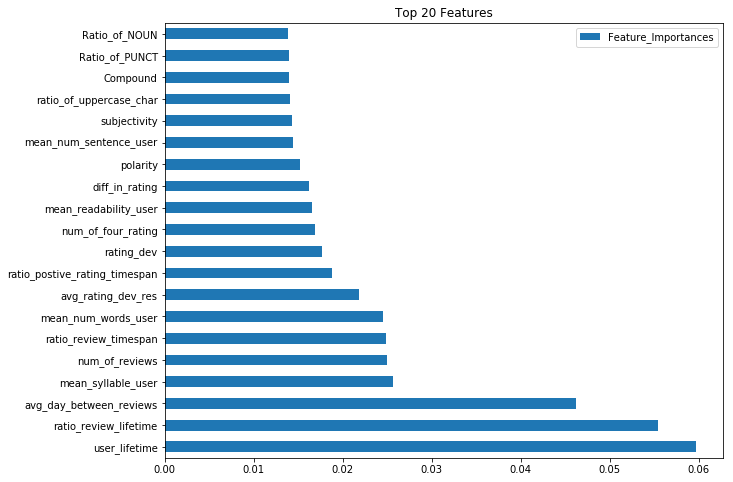

In [82]:
impt_features_user_review.sort_values(by=['Feature_Importances'],ascending=False).head(20).plot(kind='barh',figsize=(10,8))
plt.title('Top 20 Features')

Above are the top 20 most important features by random forest classifier. I intend to use the above features only to do predictions.

In [78]:
impt_features_user_review.sort_values(by=['Feature_Importances'],ascending=False).head(20).index

Index(['user_lifetime', 'ratio_review_lifetime', 'avg_day_between_reviews',
       'mean_syllable_user', 'num_of_reviews', 'ratio_review_timespan',
       'mean_num_words_user', 'avg_rating_dev_res',
       'ratio_postive_rating_timespan', 'rating_dev', 'num_of_four_rating',
       'mean_readability_user', 'diff_in_rating', 'polarity',
       'mean_num_sentence_user', 'subjectivity', 'ratio_of_uppercase_char',
       'Compound', 'Ratio_of_PUNCT', 'Ratio_of_NOUN'],
      dtype='object')

In [79]:
user_review_features = ['user_lifetime', 'ratio_review_lifetime', 'avg_day_between_reviews',
       'mean_syllable_user', 'num_of_reviews', 'ratio_review_timespan',
       'mean_num_words_user', 'avg_rating_dev_res',
       'ratio_postive_rating_timespan', 'rating_dev', 'num_of_four_rating',
       'mean_readability_user', 'diff_in_rating', 'polarity',
       'mean_num_sentence_user', 'subjectivity', 'ratio_of_uppercase_char',
       'Compound', 'Ratio_of_PUNCT', 'Ratio_of_NOUN']

In [80]:
ss = StandardScaler()
train_review_user_sc = ss.fit_transform(X_train[user_review_features])
test_review_user_sc = ss.transform(X_test[user_review_features])

In [53]:
rt = RandomForestClassifier(max_depth=50,n_estimators=550, n_jobs=-1, class_weight={0:1, 1:2}) 
rt.fit(train_review_user_sc, y_train)
print(rt.score(train_review_user_sc, y_train))
print(rt.score(test_review_user_sc, y_test))

0.9999494029548675
0.781011649527568


By using only 20 features, The model is able to achieve a similar accuracy VS using user features only.<br>
<br>
This model uses features from user and review, whereas the previous model uses user features only. The previous model is predicting on user being spammer which is not what we want. This model looks at review features as well. So it does not classify based solely on user.<br>
<br>
Next I will perform gridsearch for the best parameters for Random Forest classifier.

In [66]:
pipe_rt = Pipeline([
    ('rt', RandomForestClassifier())])
pipe_params = {
    'rt__n_estimators': [850,900,950],
    'rt__max_depth': [35,40,45],
    'rt__class_weight': [{0:1, 1:1},{0:1, 1:2},{0:1, 1:3}]
}
gs_rt = GridSearchCV(pipe_rt, param_grid=pipe_params, cv=5, n_jobs=-1)

In [67]:
gs_rt.fit(train_review_user_sc, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('et', ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'et__n_estimators': [850, 900, 950], 'et__max_depth': [35, 40, 45], 'et__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [68]:
print(gs_rt.best_params_)
print(gs_rt.best_score_)

{'et__class_weight': {0: 1, 1: 2}, 'et__max_depth': 35, 'et__n_estimators': 950}
0.79035114349322


In [23]:
rt = RandomForestClassifier(max_depth=35,n_estimators=950, n_jobs=-1, class_weight={0:1, 1:2}) 
rt.fit(train_review_user_sc, y_train)
print(rt.score(train_review_user_sc, y_train))
print(rt.score(test_review_user_sc, y_test))

0.9999494029548675
0.7804045080256518


In [54]:
cm=confusion_matrix(y_test, rt.predict(test_review_user_sc))

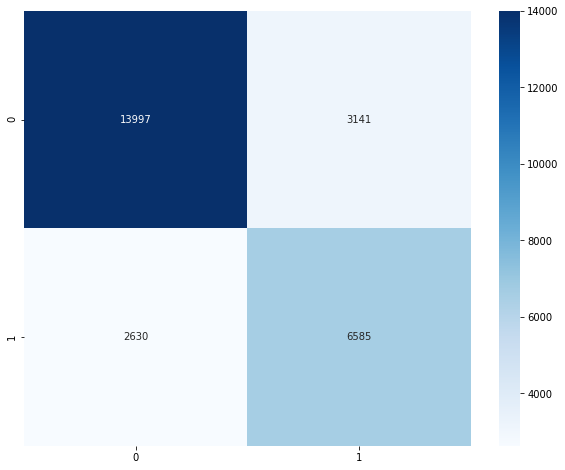

In [55]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot = True,cmap = 'Blues', fmt='g')

In [56]:
tn, fp, fn, tp=confusion_matrix(y_test, rt.predict(test_review_user_sc)).ravel()

print(f'Accuracy = {round((tp + tn) /(tn+ fp+ fn+ tp),3)}')
print(f'Misclassification Rate = {round((fp + fn) /(tn+ fp+ fn+ tp),3)}')
print(f'Sensitivity = {round(tp /(fn+ tp),3)}')
print(f'Specificity = {round(tn /(fp+ tn),3)}')
print(f'Precision = {round(tp /(fp+ tp),3)}')

print(classification_report(y_test, rt.predict(test_review_user_sc), target_names=['0','1']))

pred_proba = [i[1] for i in rt.predict_proba(test_review_user_sc)]

pred_df = pd.DataFrame({'true_values': y_test, # Creating Dataframe to store all the true y
                        'pred_probs':pred_proba})

print(roc_auc_score(y_test,pred_proba))

Accuracy = 0.781
Misclassification Rate = 0.219
Sensitivity = 0.715
Specificity = 0.817
Precision = 0.677
             precision    recall  f1-score   support

          0       0.84      0.82      0.83     17138
          1       0.68      0.71      0.70      9215

avg / total       0.78      0.78      0.78     26353

0.8712393068251232


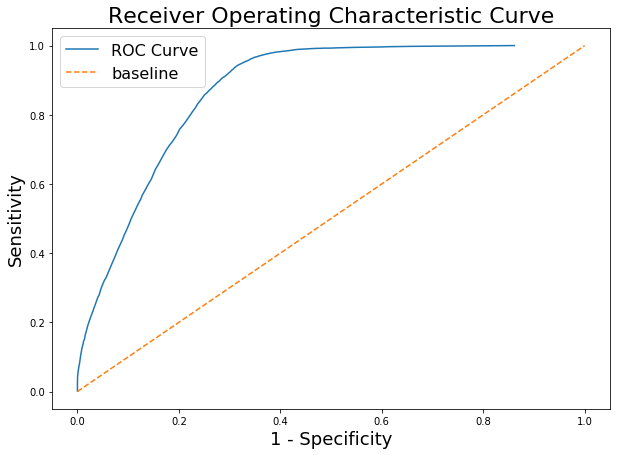

In [57]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_nb_cvec = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_nb_cvec = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values_nb_cvec, # False Positive Rate on X-axis
         tpr_values_nb_cvec, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

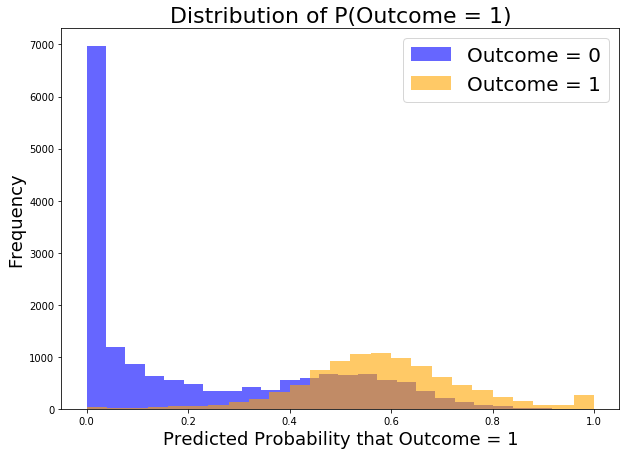

In [58]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

ROC score is lower at 0.87. There are more misclassifications and more overlapping of the class 0 and 1..<br>
<br>
However this model is still preferred as it does not target solely on users. It looks at the review features as well so it will encourage better content and quality review.

## Predictions using review features and user clusters

In this section, I will be using the review features and user clusters to make predictions. The main motivation for using user clusters is to build a model that we can deploy to predict future reviews. Future reviews' users can be clustered into these clusters based on their user's statistics and along with the review features to make predictions.

In [229]:
cluster_review_features = ['prod_avg_rating', 'num_of_char', 'num_of_words', 'difficult_words',
       'avg_character_per_word', 'syllable_count', 'avg_syllables_per_word',
       'sentence_count', 'avg_sentence_length', 'avg_sentence_per_word',
       'flesch_reading_ease', 'num_of_stopwords', 'num_of_numerics',
       'num_of_unique_words', 'num_of_uppercase_char',
       'ratio_of_uppercase_char', 'ratio_of_difficult_words',
       'ratio_of_unique_words', 'polarity', 'subjectivity', 'Negative',
       'Neutral', 'Positive', 'Compound', 'ADJ', 'ADP', 'ADV', 'AUX',
       'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT',
       'SCONJ', 'SPACE', 'SYM', 'VERB', 'X', 'Ratio_of_ADJ', 'Ratio_of_ADP',
       'Ratio_of_ADV', 'Ratio_of_AUX', 'Ratio_of_CCONJ', 'Ratio_of_DET',
       'Ratio_of_INTJ', 'Ratio_of_NOUN', 'Ratio_of_NUM', 'Ratio_of_PART',
       'Ratio_of_PRON', 'Ratio_of_PROPN', 'Ratio_of_PUNCT', 'Ratio_of_SCONJ',
       'Ratio_of_SPACE', 'Ratio_of_SYM', 'Ratio_of_VERB', 'Ratio_of_X',
       'diff_in_rating', 'cluster']

In [230]:
X_train_cluster = pd.get_dummies(X_train[cluster_review_features],columns=['cluster'])
X_test_cluster = pd.get_dummies(X_test[cluster_review_features],columns=['cluster'])

In [236]:
ss = StandardScaler()
train_review_cluster_sc = ss.fit_transform(X_train_cluster)
test_review_cluster_sc = ss.transform(X_test_cluster)

In [237]:
lr=LogisticRegression() 
lr.fit(train_review_cluster_sc, y_train)
print(lr.score(train_review_cluster_sc, y_train))
print(lr.score(test_review_cluster_sc, y_test))

0.7058287795992714
0.7025765567487573


In [238]:
rt = RandomForestClassifier(max_depth=30,n_estimators=550, n_jobs=-1, class_weight={0:1, 1:2}) 
rt.fit(train_review_cluster_sc, y_train)
print(rt.score(train_review_cluster_sc, y_train))
print(rt.score(test_review_cluster_sc, y_test))

0.9998229103420361
0.7071301180131294


In [239]:
et = ExtraTreesClassifier(n_estimators=550, max_depth=40, n_jobs=-1,class_weight={0:1, 1:2})
et.fit(train_review_cluster_sc, y_train)
print(et.score(train_review_cluster_sc, y_train))
print(et.score(test_review_cluster_sc, y_test))

0.9998102610807529
0.7065229765112131


From the above results, accuracy had dropped to close to baseline accuracy. 

In [240]:
prediction = rt.predict(test_review_cluster_sc)

In [241]:
cm=confusion_matrix(y_test, prediction)

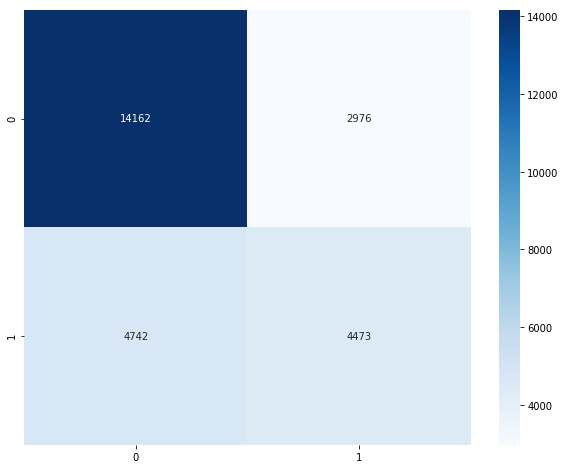

In [242]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot = True,cmap = 'Blues', fmt='g')

In [244]:
tn, fp, fn, tp=confusion_matrix(y_test, prediction).ravel()

print(f'Accuracy = {round((tp + tn) /(tn+ fp+ fn+ tp),3)}')
print(f'Misclassification Rate = {round((fp + fn) /(tn+ fp+ fn+ tp),3)}')
print(f'Sensitivity = {round(tp /(fn+ tp),3)}')
print(f'Specificity = {round(tn /(fp+ tn),3)}')
print(f'Precision = {round(tp /(fp+ tp),3)}')

print(classification_report(y_test, prediction, target_names=['0','1']))

pred_proba = [i[1] for i in rt.predict_proba(test_review_cluster_sc)]

pred_df = pd.DataFrame({'true_values': y_test, # Creating Dataframe to store all the true y
                        'pred_probs':pred_proba})

print(roc_auc_score(y_test,pred_proba))

Accuracy = 0.707
Misclassification Rate = 0.293
Sensitivity = 0.485
Specificity = 0.826
Precision = 0.6
             precision    recall  f1-score   support

          0       0.75      0.83      0.79     17138
          1       0.60      0.49      0.54      9215

avg / total       0.70      0.71      0.70     26353

0.7746033174763959


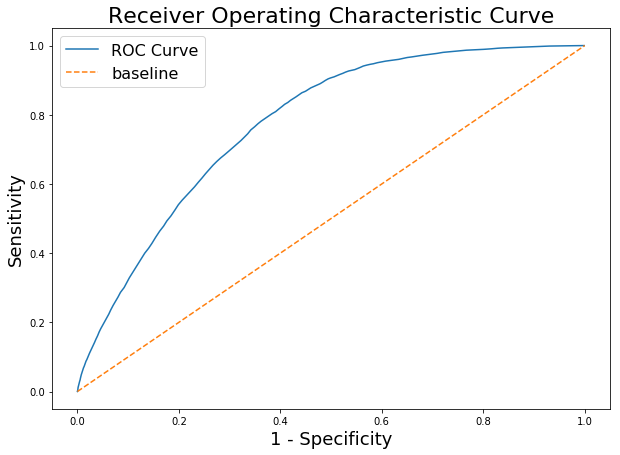

In [245]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_nb_cvec = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_nb_cvec = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values_nb_cvec, # False Positive Rate on X-axis
         tpr_values_nb_cvec, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

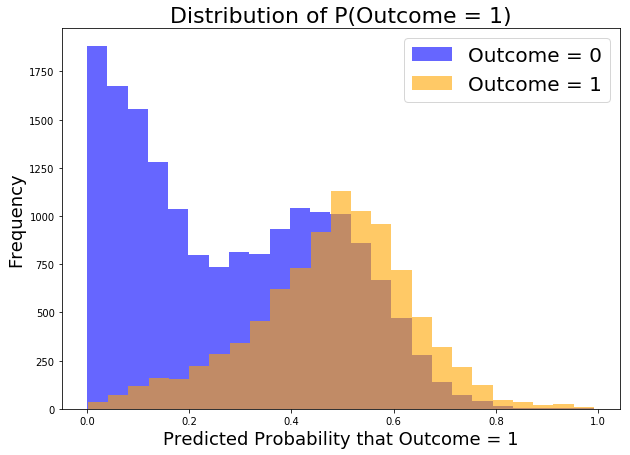

In [246]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

ROC score had dropped to 0.77 with half of the spam/fake review misclasified as real review.<br>
<br>
Grouping users into clusters may have lose a lot of infomation about the users hence the model is not able to learn the distinct behavior of users.  

# Conclusion / Recommendations

Restuarants are willing to pay to buy machine-generated / human written reviews which looks very much like genuine reviews to boost their reputation online. Based on review text alone, its not sufficient to determine which review are spam or genuine.<br>
From the model, some review features like polarity, subjectively, compound and difference in rating from the restaurant's average rating is important. Fake reviews tend to be more polarized. Fake reviewers would also give ratings that are on the extreme scale to make an impact to the business repution.<br>
<br>
User's behvaior is critical to make this prediction. Fake reviewers are generally lower lifetime, post more reviews in a short time and the rating given are generally deviated from the average rating of restaurant.<br>
<br>
For genuine users who have their reviews flagged out frequently, they should try to post reviews that are more objective and avoid posting multiple reviews on the same day.<br>
<br>
This model involves studying user's behavior and its challenges lies in predicting single review users and new users.

# Reference

[1] Shebuti Rayana and Leman Akoglu. Collective Opinion Spam Detection: Bridging Review Networks and metadata. Proceeding of the 21st ACM SIGKDD international conference on Knowledge discovery and data mining. KDD’15. 2015<br>
<br>
[2] Karen Weisee. A Lie Detector Test for Online Reviewers 2011.  https://www.bloomberg.com/news/articles/2011-09-29/a-lie-detector-test-for-online-reviewers <br>
<br>
[3] Yao, Yao; Angelov, Ivelin; Rasmus-Vorrath, Jack; Lee, Mooyoung; and Engels, Daniel W. (2018) "Yelp’s Review Filtering Algorithm,"SMU Data Science Review: Vol. 1 : No. 3 , Article 3.
Available at: https://scholar.smu.edu/datasciencereview/vol1/iss3/3 <br>
<br>
[4] Yichen Wang and Tao Ruan. Online Fake Review Detection on Yelp Data. 2018 <br>
<br>
[5] Kaushik Varadha Rajan, Nivasse Ajagane, Shubham Srivastav. Evaluating Performance of Semi-Supervised
Self Training in Identifying Fake Reviews North Carolina State University , Raleigh NC 27606, USA <br>
<br>
[6] Santosh Kumar Ghosh and Saransh Zargar. Detection Of Review Spam in Online Review websites. 2015 <br>
<br>
[7] Martens, D. & Maalej, W. Empir Software Eng (2019). https://doi.org/10.1007/s10664-019-09706-9